### An example of training a [TabNet](https://github.com/dreamquark-ai/tabnet) with data generated by a Gaussian Random Field (GRF), followed by an explanation using GeoShapley.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from gstools import SRF, Gaussian,CovModel
import xgboost as xgb
from sklearn.model_selection import train_test_split

### Generating synthetic data

In [2]:
class GWR_gau(CovModel):
    def correlation(self,r):
        return np.exp(-0.5*(r/self.len_scale)**2)

In [3]:
def plot_1(b,title='',vmin=1,vmax=6):
    size=50
    plt.imshow(b.reshape(size,size),cmap=plt.cm.get_cmap('bwr',21),vmin=vmin,vmax=vmax)
    plt.title(title)
    plt.colorbar()

In [4]:
size=50
model = GWR_gau(dim=2, var=2,len_scale=5)
srf = SRF(model,mean=2,seed=10)
b1 = srf.structured([range(size),range(size)]).reshape(-1)
b1 = b1 - b1.mean() + 2

In [5]:
size=50
model = GWR_gau(dim=2, var=2,len_scale=15)
srf = SRF(model,mean=2,seed=20)
b2 = srf.structured([range(size),range(size)]).reshape(-1)
b2 = b2 - b2.mean() + 2

In [6]:
size=50
def plot_s(bs,vmin=None,vmax=None, title = ""):
    k = len(bs)
    fig, axs = plt.subplots(1, k,figsize=(6*k,4),dpi=300)
    for i in range(k):
        ax = axs[i].imshow(bs[i].reshape(size,size),cmap=plt.cm.get_cmap('viridis',36),
                               vmin=vmin,vmax=vmax,interpolation=None)
        
        fig.colorbar(ax, ax=axs[i])

        axs[i].set_xticks(np.arange(-0.5, size, 5))
        axs[i].set_yticks(np.arange(-0.5, size, 5))
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        axs[i].tick_params(axis='x', colors=(0,0,0,0))
        axs[i].tick_params(axis='y', colors=(0,0,0,0))
        
    fig.suptitle(title, fontsize=20,y=1)

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_40247/2208071456.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax = axs[i].imshow(bs[i].reshape(size,size),cmap=plt.cm.get_cmap('viridis',36),


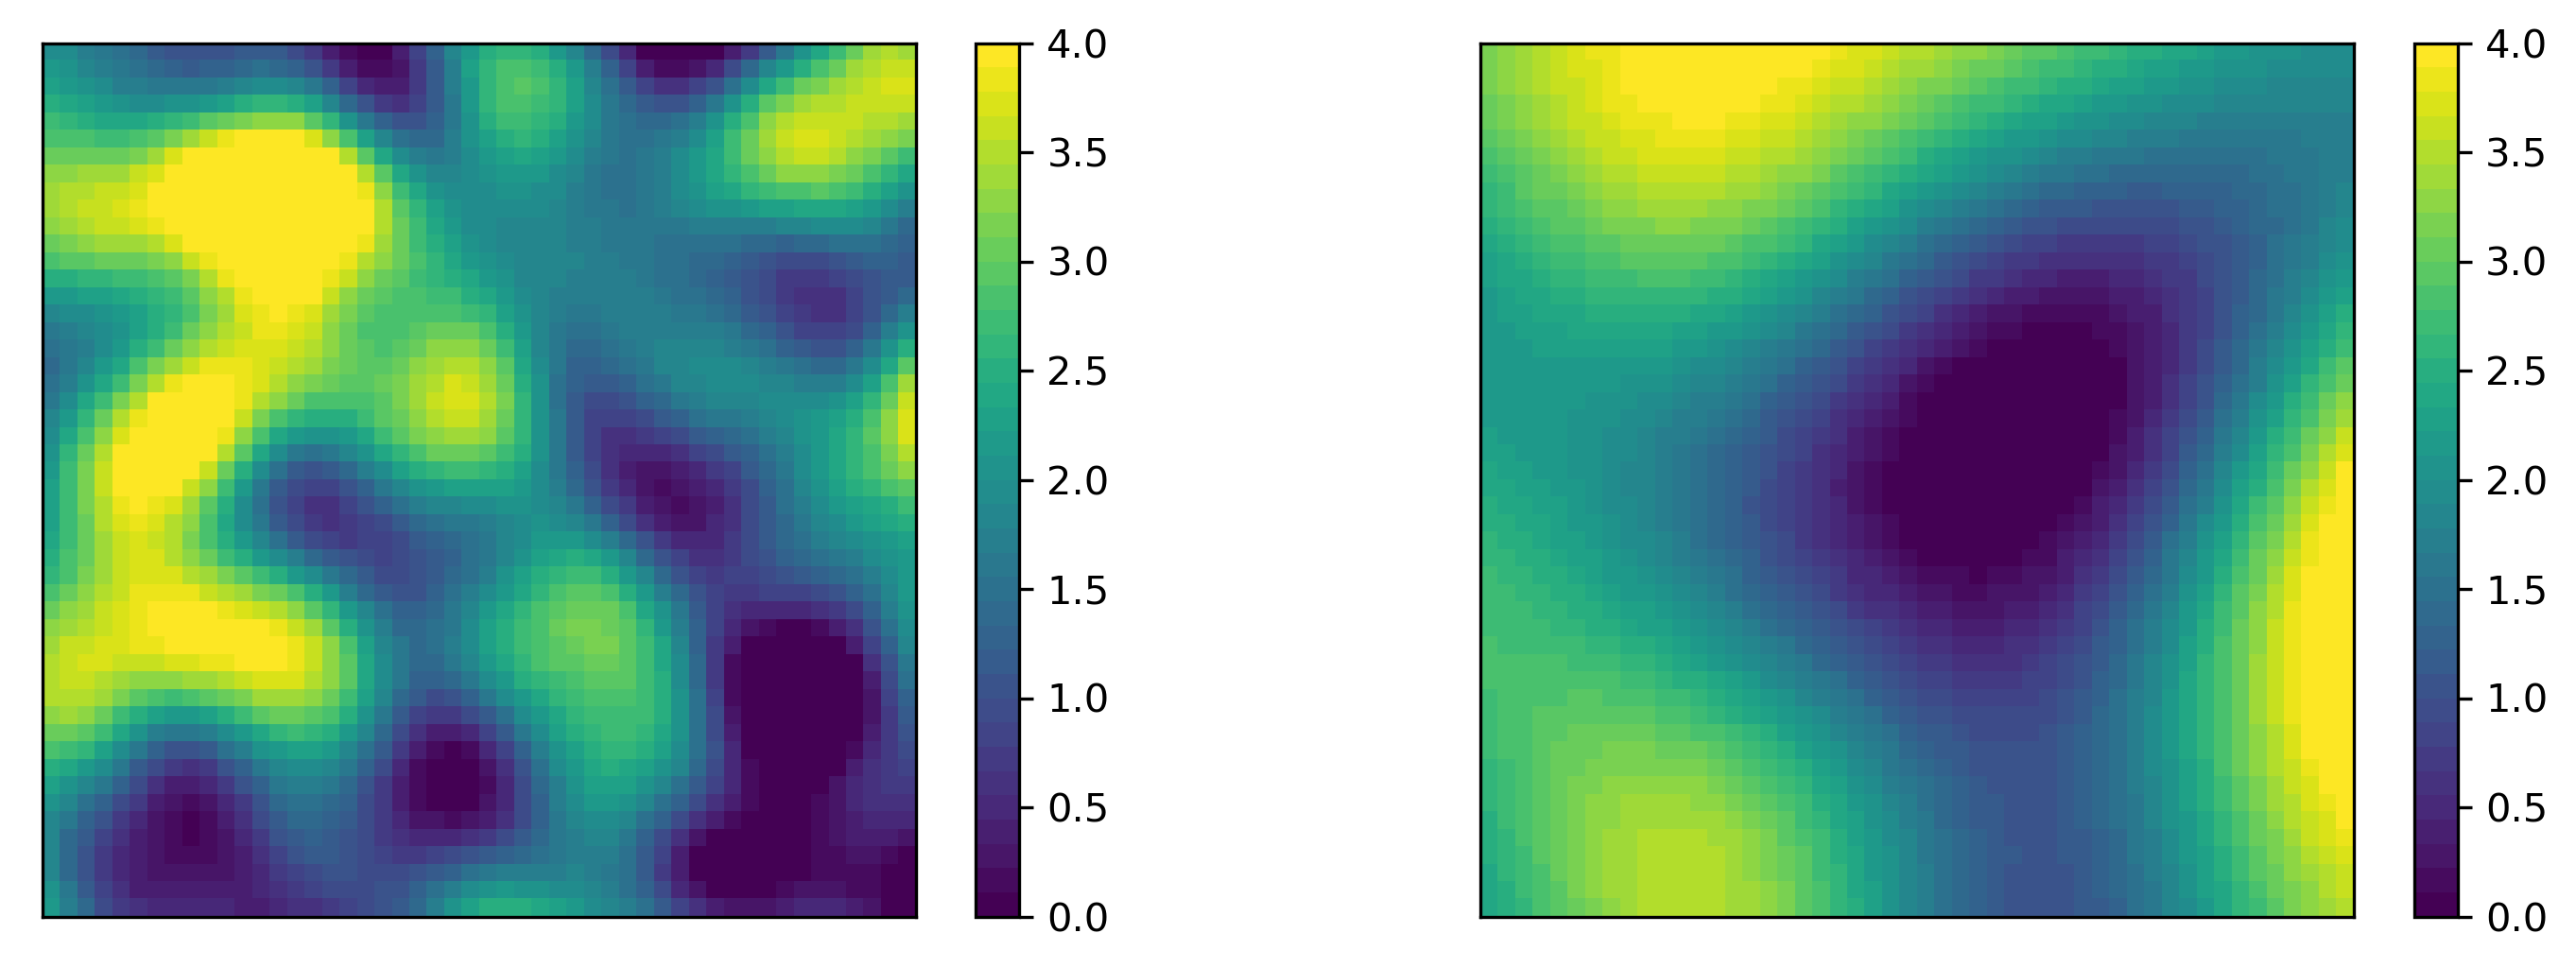

In [7]:
plot_s(np.vstack([b1, b2]),vmin=0,vmax=4)

In [8]:
np.random.seed(111)

X1 = np.random.uniform(-1.5,1.5,size*size)
X2 = np.random.uniform(-1.5,1.5,size*size)

X = np.vstack([X1,X2]).T

u = np.array([np.linspace(0,size-1,num=size)]*size).reshape(-1)
v = np.array([np.linspace(0,size-1,num=size)]*size).T.reshape(-1)
coords = np.array(list(zip(u,v)))

In [9]:
b0 = np.ones(size*size)*3

In [10]:
np.random.seed(111)

f0 = b0
f1 = b1*X1
f2 = b2*X2

err = np.random.randn(size*size)*1

y = (f0 + f1 + f2 + err).reshape(-1,1)

In [11]:
X_coords = pd.DataFrame(X, columns=['X1','X2'])

In [12]:
data = X_coords.copy()
data[['y','b0','b1','b2']] = np.vstack([y.reshape(-1),b0,b1,b2]).T
data.to_csv("grf_example.csv")

In [13]:
1 - np.sum((err)**2)/np.sum((y-y.mean())**2)

0.8890567123755463

In [14]:
#moran_names = ["moran_" + str(i) for i in range(moran.shape[1])]
X_coords.loc[:,['u','v']] = (np.array(coords) - np.array(coords).mean(axis=0))/np.array(coords).std(axis=0)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_coords, y.reshape(-1,1), test_size=0.20, random_state=42)

### Train a TabNet Model

In [16]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold

import optuna
import torch
from optuna import Trial, visualization

In [17]:
def Objective(trial):
    mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
    n_da = trial.suggest_int("n_da", 56, 64, step=4)
    n_steps = trial.suggest_int("n_steps", 1, 5, step=1)
    gamma = trial.suggest_float("gamma", 1., 1.6, step=0.1)
    n_shared = trial.suggest_int("n_shared", 1, 5)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-8, 1e-3, log=True)
    tabnet_params = dict(n_d=n_da, n_a=n_da, n_steps=n_steps, gamma=gamma,
                     lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=mask_type, n_shared=n_shared,
                     scheduler_params=dict(mode="min",
                                           patience=trial.suggest_int("patienceScheduler",low=10,high=25), # changing sheduler patience to be lower than early stopping patience 
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=0,
                     ) #early stopping
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    
    CV_score_array = []
    for train_index, test_index in kf.split(X_coords):
        X_train, X_valid = X_coords.values[train_index], X_coords.values[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        regressor = TabNetRegressor(**tabnet_params)
        regressor.fit(X_train=X_train, y_train=y_train,
                  eval_set=[(X_valid, y_valid)],
                  patience=trial.suggest_int("patience",low=30,high=100), max_epochs=trial.suggest_int('epochs', 50, 500),
                  eval_metric=['rmse'])
        CV_score_array.append(regressor.best_cost)
    avg = np.mean(CV_score_array)
    return avg

In [18]:
%%time
study = optuna.create_study(direction="minimize", study_name='TabNet optimization')

study.optimize(Objective, timeout=60*5) #5 hours

[I 2024-03-27 17:16:04,319] A new study created in memory with name: TabNet optimization


Stop training because you reached max_epochs = 163 with best_epoch = 154 and best_val_0_rmse = 1.29226


/Users/ziqili/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 163 with best_epoch = 156 and best_val_0_rmse = 1.21115


/Users/ziqili/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 163 with best_epoch = 160 and best_val_0_rmse = 1.21077


/Users/ziqili/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 163 with best_epoch = 145 and best_val_0_rmse = 1.20571


/Users/ziqili/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-03-27 17:17:22,814] Trial 0 finished with value: 1.2211917934696568 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.1, 'n_shared': 4, 'lambda_sparse': 2.9127705786841596e-06, 'patienceScheduler': 23, 'patience': 77, 'epochs': 163}. Best is trial 0 with value: 1.2211917934696568.


Stop training because you reached max_epochs = 163 with best_epoch = 146 and best_val_0_rmse = 1.18608
Stop training because you reached max_epochs = 112 with best_epoch = 111 and best_val_0_rmse = 1.29458


/Users/ziqili/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 112 with best_epoch = 109 and best_val_0_rmse = 1.28405


/Users/ziqili/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 112 with best_epoch = 69 and best_val_0_rmse = 1.28587


/Users/ziqili/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 112 with best_epoch = 88 and best_val_0_rmse = 1.2836


/Users/ziqili/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-03-27 17:18:59,644] Trial 1 finished with value: 1.288709397562861 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 5, 'gamma': 1.1, 'n_shared': 4, 'lambda_sparse': 1.697200070786912e-05, 'patienceScheduler': 24, 'patience': 50, 'epochs': 112}. Best is trial 0 with value: 1.2211917934696568.


Stop training because you reached max_epochs = 112 with best_epoch = 101 and best_val_0_rmse = 1.29545

Early stopping occurred at epoch 260 with best_epoch = 175 and best_val_0_rmse = 1.33976


/Users/ziqili/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 288 with best_epoch = 235 and best_val_0_rmse = 1.25091


/Users/ziqili/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 288 with best_epoch = 274 and best_val_0_rmse = 1.22032


/Users/ziqili/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 288 with best_epoch = 283 and best_val_0_rmse = 1.3345


/Users/ziqili/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-03-27 17:21:46,264] Trial 2 finished with value: 1.2907992635574943 and parameters: {'mask_type': 'sparsemax', 'n_da': 56, 'n_steps': 5, 'gamma': 1.5, 'n_shared': 2, 'lambda_sparse': 3.134929509571615e-05, 'patienceScheduler': 14, 'patience': 85, 'epochs': 288}. Best is trial 0 with value: 1.2211917934696568.



Early stopping occurred at epoch 262 with best_epoch = 177 and best_val_0_rmse = 1.30851
CPU times: user 10min 8s, sys: 46min 27s, total: 56min 35s
Wall time: 5min 41s


In [19]:
study.best_value

1.2211917934696568

In [20]:
TabNet_params = study.best_params

In [21]:
final_params = dict(n_d=TabNet_params['n_da'], n_a=TabNet_params['n_da'], n_steps=TabNet_params['n_steps'], gamma=TabNet_params['gamma'],
                     lambda_sparse=TabNet_params['lambda_sparse'], optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=TabNet_params['mask_type'], n_shared=TabNet_params['n_shared'],
                     scheduler_params=dict(mode="min",
                                           patience=TabNet_params['patienceScheduler'],
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=0,
                     )

epochs = TabNet_params['epochs']

In [22]:
regressor = TabNetRegressor(**final_params)
regressor.fit(X_train=X_train.values, y_train=y_train,
          patience=TabNet_params['patience'], max_epochs=epochs,
          eval_metric=['rmse'])

/Users/ziqili/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


In [23]:
from sklearn.metrics import r2_score,mean_squared_error

print("test-R2:", r2_score(y_test, regressor.predict(X_test.values)))
print("test-RMSE:", np.sqrt(mean_squared_error(y_test, regressor.predict(X_test.values))))

print("train-R2:", r2_score(y_train, regressor.predict(X_train.values)))
print("train-RMSE:", np.sqrt(mean_squared_error(y_train, regressor.predict(X_train.values))))

test-R2: 0.8025055313914277
test-RMSE: 1.3312808323256504
train-R2: 0.8659295564111267
train-RMSE: 1.1007421389417178


### GeoShapley Explanation

In [24]:
import sys
sys.path.append('/Users/ziqili/Desktop/geoshapley-main/')

from geoshapley import GeoShapleyExplainer

In [25]:
background_X = X_coords.values

In [26]:
%%time
explainer = GeoShapleyExplainer(regressor.predict, background_X)

rslt = explainer.explain(X_coords, n_jobs=-1)

  0%|          | 0/2500 [00:00<?, ?it/s]

CPU times: user 47.8 s, sys: 7.82 s, total: 55.6 s
Wall time: 22min 30s


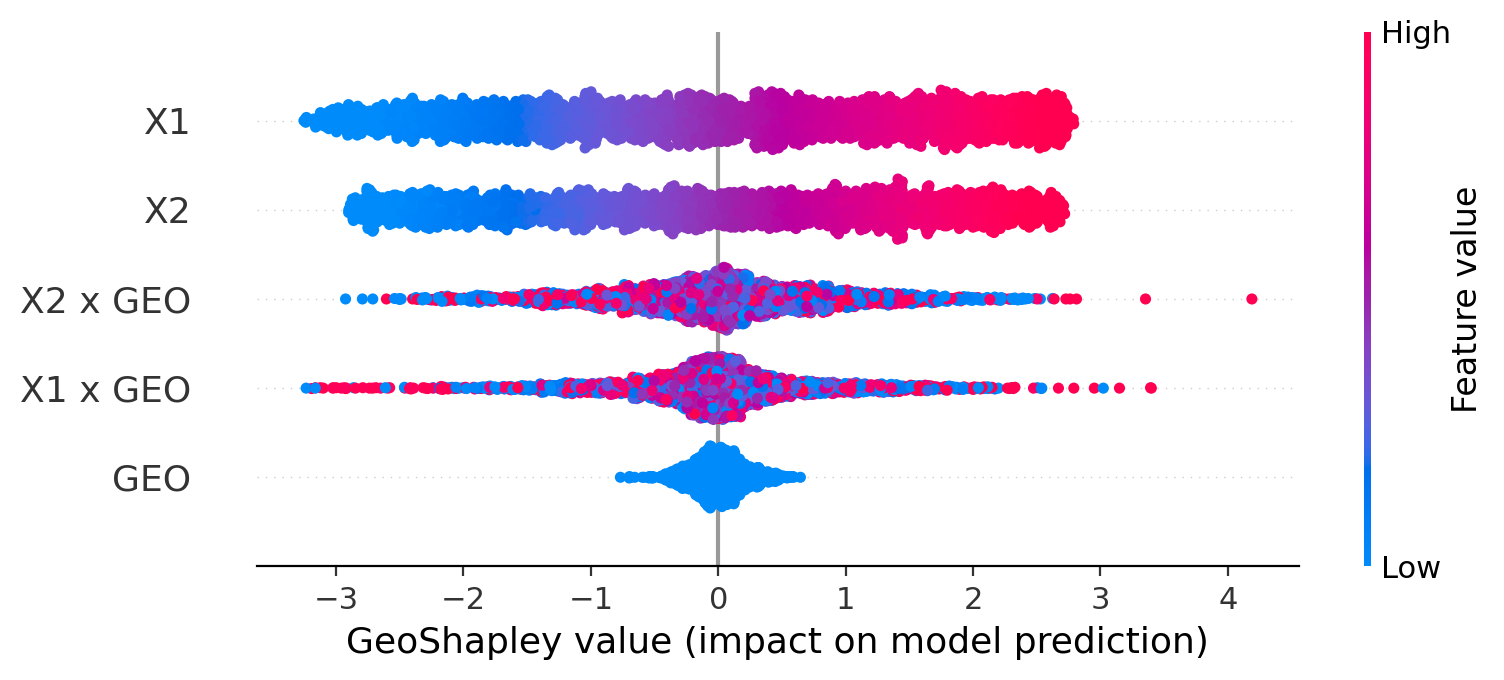

In [27]:
rslt.summary_plot()

In [28]:
svc = rslt.get_svc(col = [0, 1],coef_type="raw",include_primary=True,coords=coords)


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


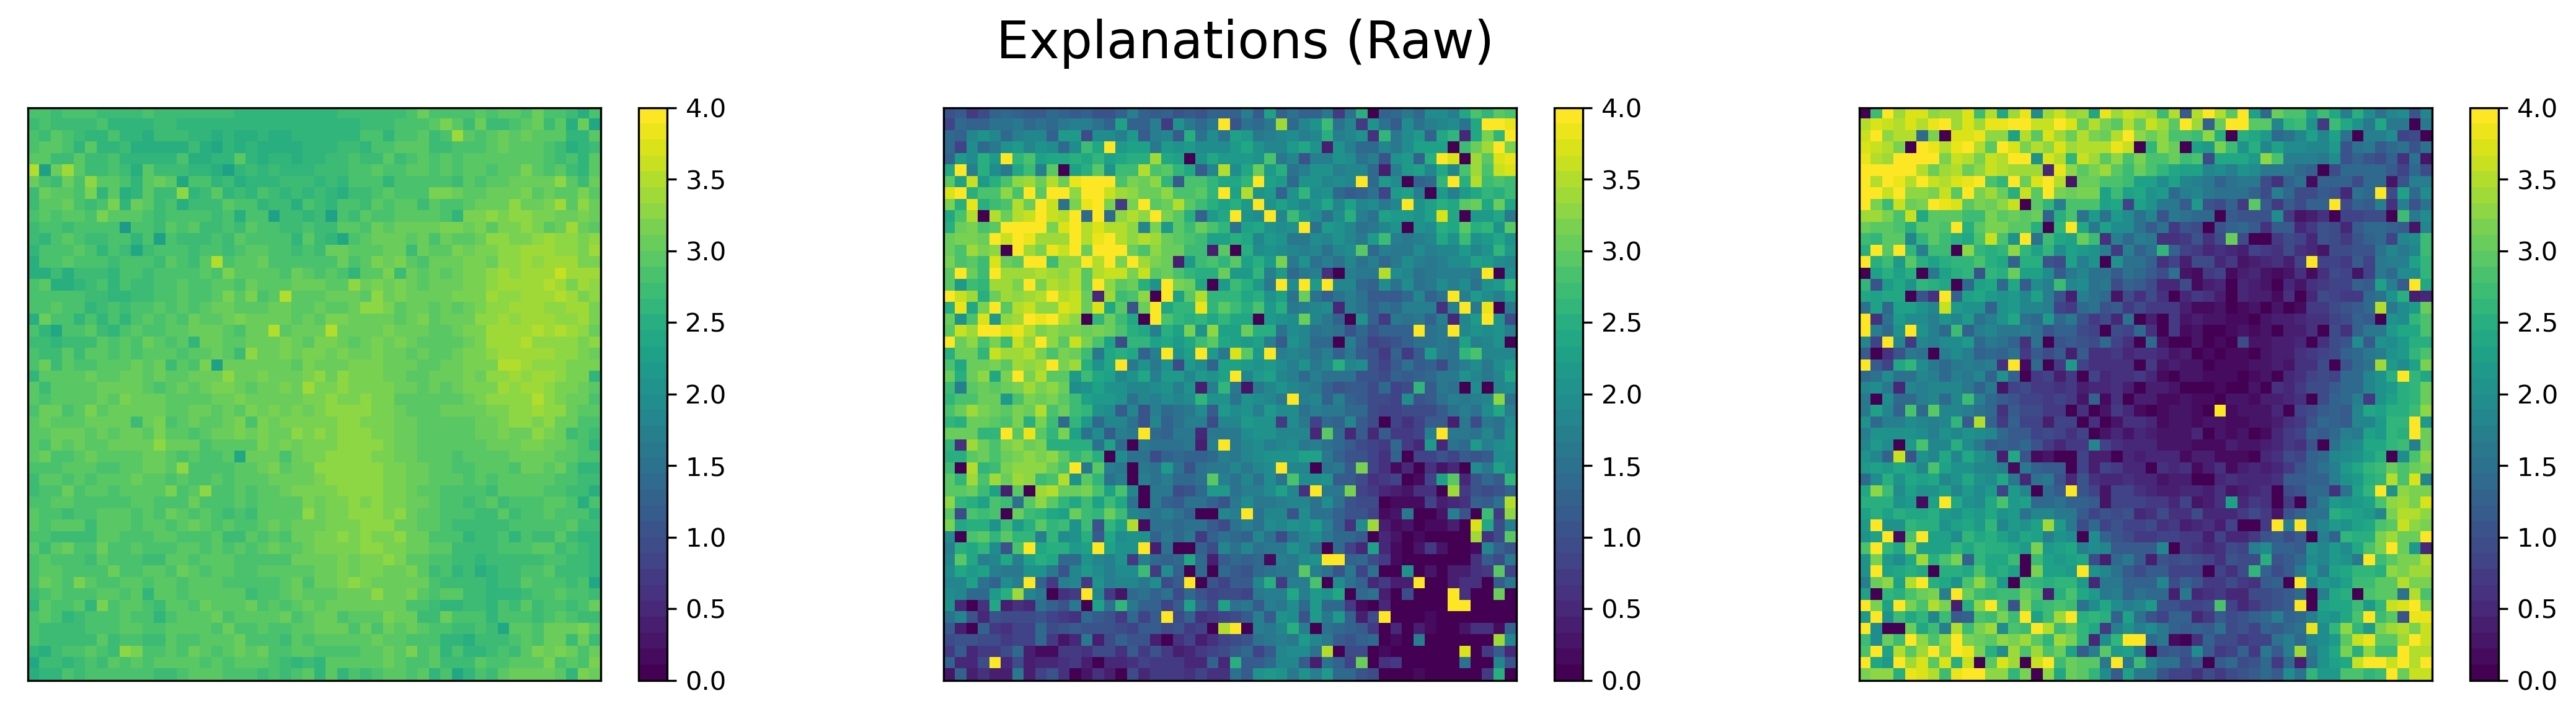

In [29]:
plot_s(np.hstack([rslt.base_value + rslt.geo.reshape(-1,1), svc]).T, title="Explanations (Raw)",vmin=0,vmax=4)

In [30]:
svc_gwr = rslt.get_svc(col = [0, 1],coef_type="gwr",include_primary=True,coords=coords)

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


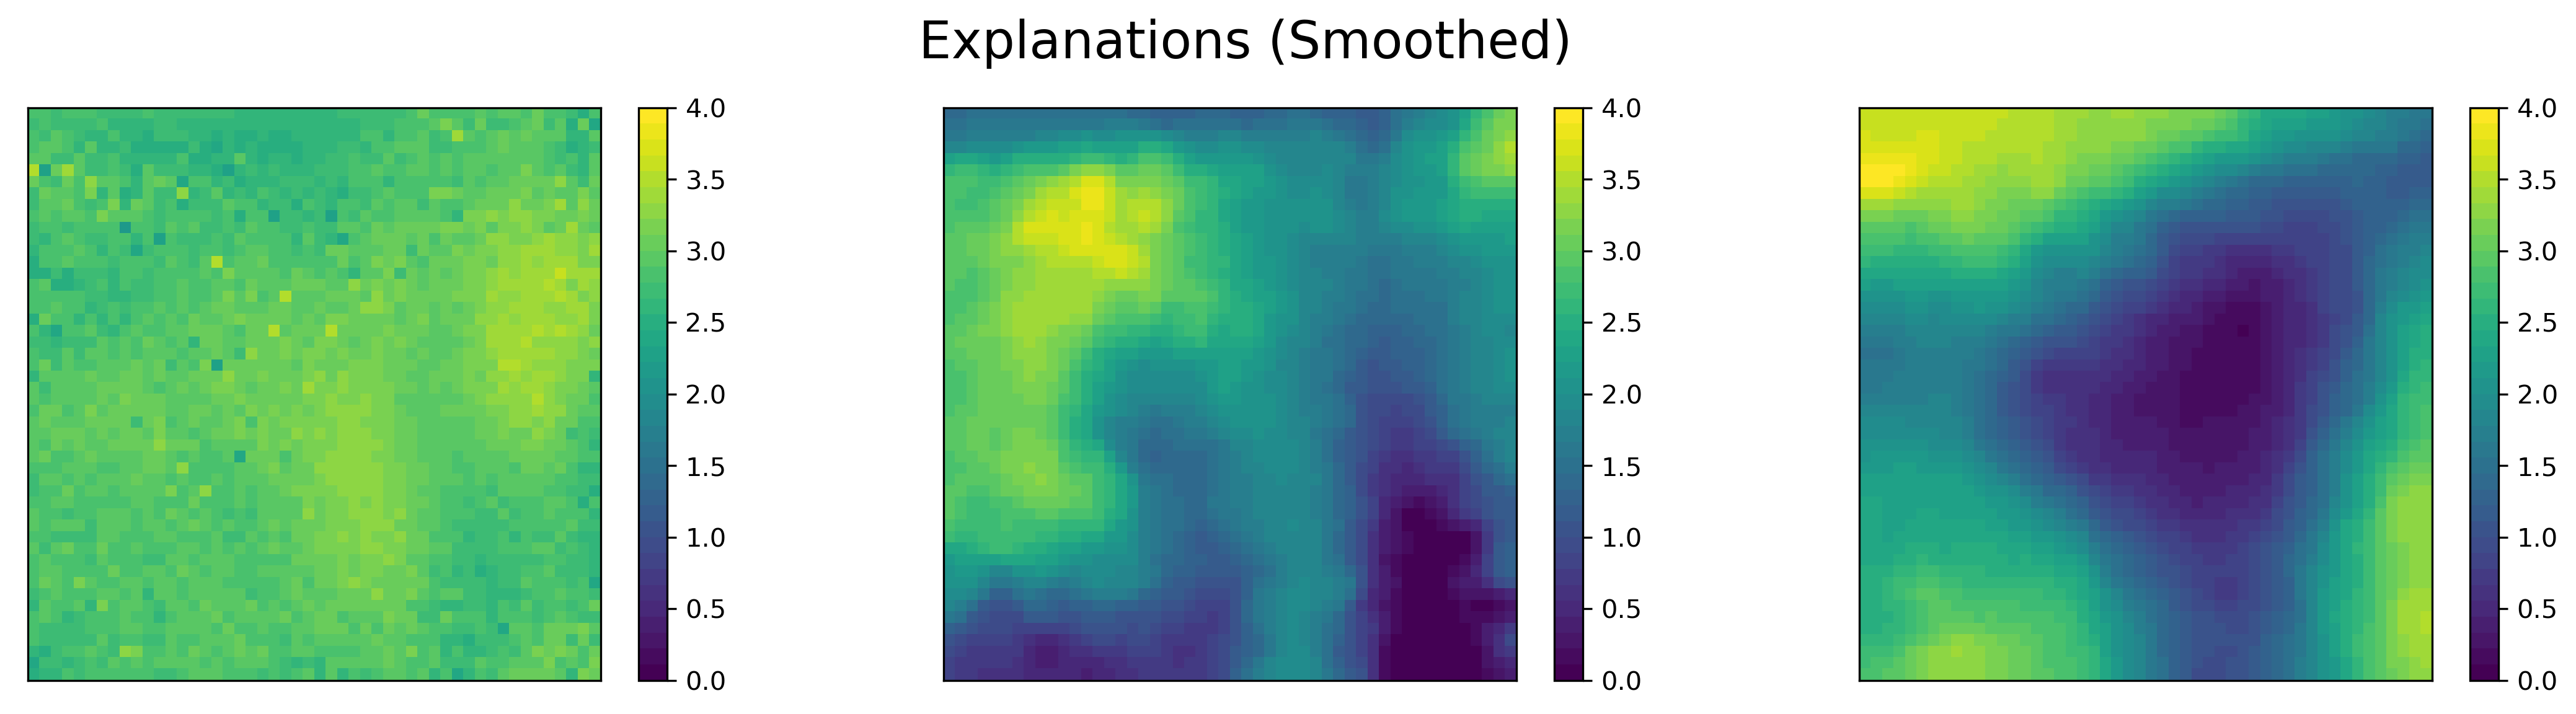

In [31]:
plot_s(np.hstack([rslt.base_value + rslt.geo.reshape(-1,1), svc_gwr]).T, title="Explanations (Smoothed)",vmin=0,vmax=4)

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


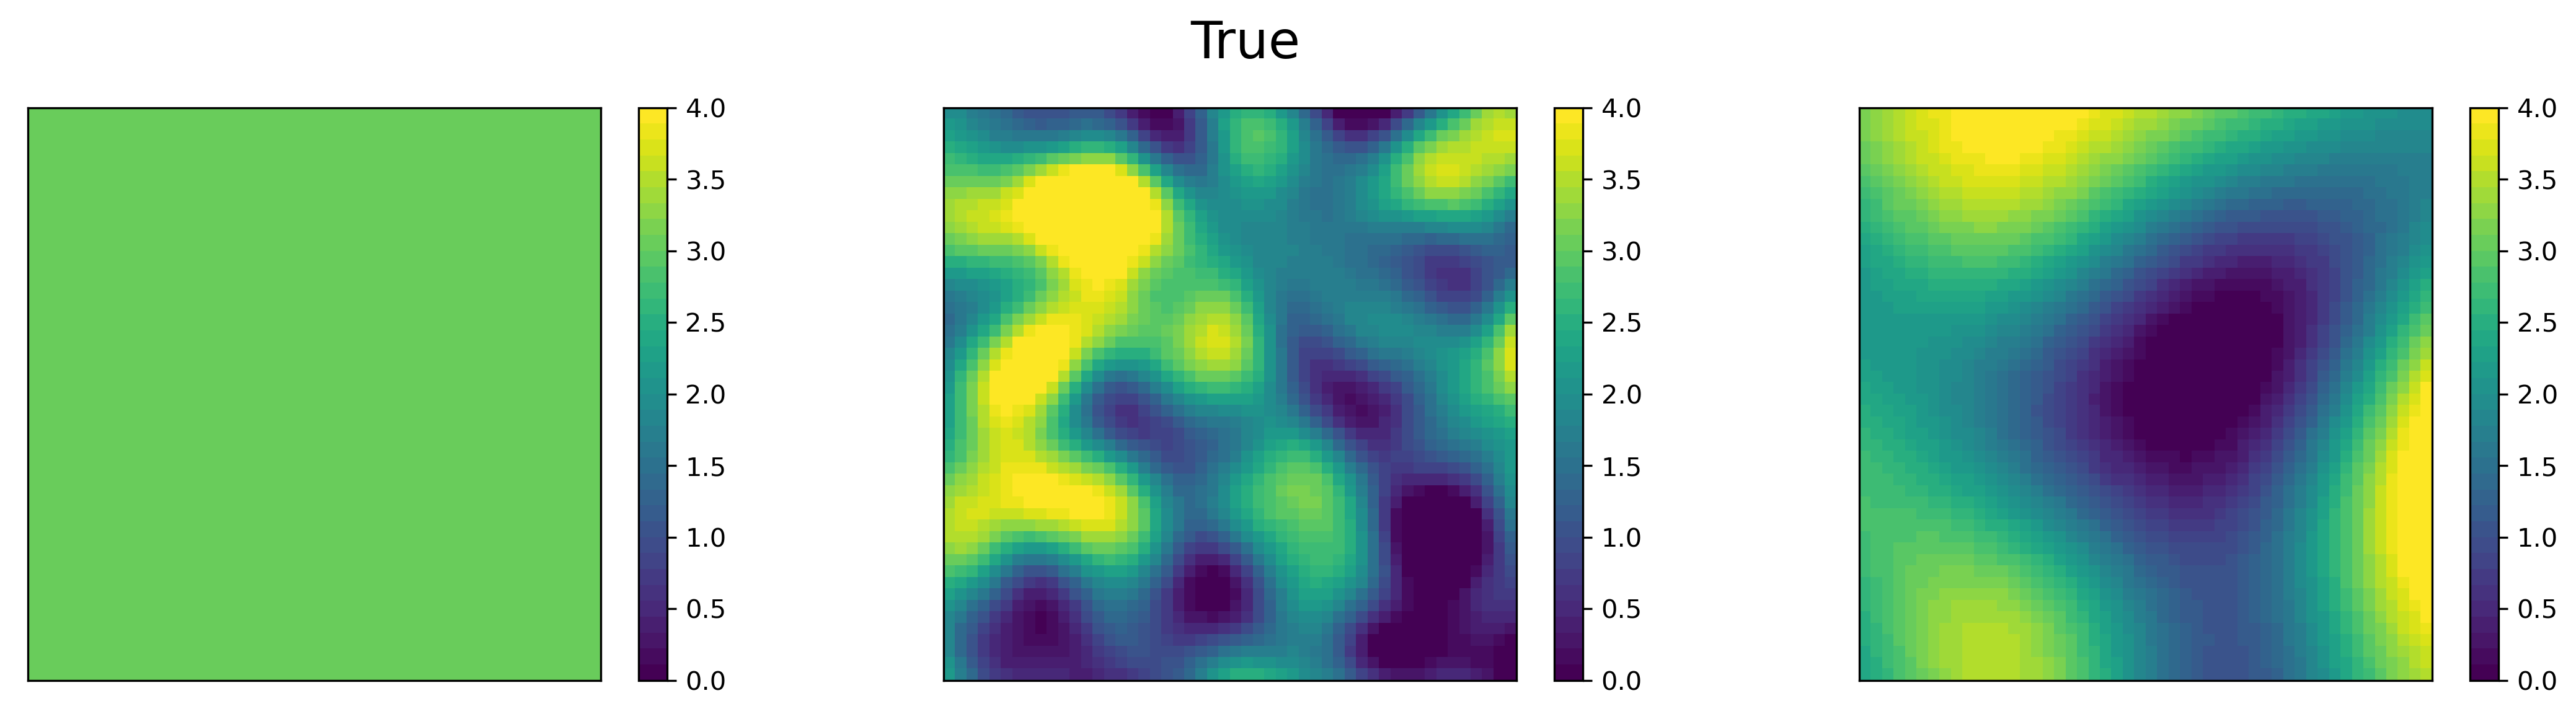

In [32]:
plot_s(np.vstack([b0,b1,b2]), title="True",vmin=0,vmax=4)